# Error versus information

In [1]:
using Statistics, StatsBase, BitInformation
using JLD2, NetCDF

path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path));

In [2]:
function SSIM(  X::AbstractArray{T},
                Y::AbstractArray{T},
                k1::Real=0.01,
                k2::Real=0.03) where T
    
    size(X) == size(Y) || throw(error("Sizes $(size(X)) and $(size(Y)) of inputs don't match."))
    
    μx = mean(X)
    μy = mean(Y)
    
    σx² = var(X,mean=μx)
    σy² = var(Y,mean=μy)
    σxy² = cov(vec(X),vec(Y))
    
    L = max(maximum(X),maximum(Y))-min(minimum(X),minimum(Y))
    c1 = convert(T,(k1*L)^2)
    c2 = convert(T,(k2*L)^2)
    
    numerator = (2μx*μy + c1)*(2σxy² + c2)
    denominator = (μx^2 + μy^2 + c1)*(σx² + σy² + c2)
    return numerator/denominator
end

SSIM (generic function with 3 methods)

In [ ]:
# pick only some variables
vars = ["o3","co2","co","aerlg","aermr06","ch4","no2","so2","q"]
nvars = length(vars)
varnames = fill("",nvars)

# round to
keepbits = collect(1:20)
nkeepbits = length(keepbits)

# preallocation
dec_error = fill(0f0,nvars,nkeepbits)  # decimal error
pres_info = fill(0.0,nvars,nkeepbits)  # preserved information
ssim = fill(0.0,nvars,nkeepbits)       # structural similarity index
ssimlog = fill(0.0,nvars,nkeepbits)    # ssim of log(data)

ivar = 0
for (i,file) in enumerate(filelist)
    varname = split(split(file,"cams_")[end],"_2019")[1]
    
    if varname in vars
        ivar += 1
        varnames[ivar] = varname
        print("$varname ")
        ncfile = NetCDF.open(joinpath(path,file))
    
        # find the variable name by size
        var = [var for var in ncfile.vars if prod(size(var[2])) == 900*451*137][1][1]
        X = ncfile.vars[var][:,:,:]    # exclude soutpole & northpole    

        # BITINFORMATION
        bi = bitinformation(X)
        print("B")
        
        for (k,keepbit) in enumerate(keepbits)
            print("$k")
            Xr = shave(X,keepbit)
                        
            # PRESERVED INFORMATION
            R = redundancy(X,Xr)
            pres_info[ivar,k] = (R'*bi)/sum(bi)*100
        
            # DECIMAL ERROR
            decerr = abs.(log10.(abs.(X./Xr)))

            decerr = sort(vec(decerr))
            dec_error[ivar,k] = quantile(decerr,.5,sorted=true)
            
            # STRUCTURAL SIMILARITY
            # convert to Float64 to avoid precision issues in cov
            XF64 = Float64.(X)
            XrF64 = Float64.(Xr)
            ssim[ivar,k] = SSIM(XF64,XrF64)
            
            # of logarithmic data
            XF64 = log10.(abs.(XF64))
            XrF64 = log10.(abs.(XrF64))
            ssimlog[ivar,k] = SSIM(XF64,XrF64)
        end
        print("\n")
    end
end

@save joinpath(path,"..","analysis/error_vs_info_vs_ssim.jld2") varnames keepbits dec_error pres_info ssim ssimlog
# @save joinpath(path,"..","analysis/error_vs_info.jld2") varnames keepbits dec_error pres_info

aerlg B1234567891011121314151617181920
aermr06 B1234567891011121314151617181920
ch4 B1234567891011121314151617181920
co2 B1234567891011121314151617181920
co B1234567891011121314151617181920
no2 B1234567

In [3]:
@load joinpath(path,"..","analysis/error_vs_info_vs_ssim.jld2") varnames keepbits dec_error pres_info ssim ssimlog
# @load joinpath(path,"..","analysis/error_vs_info.jld2") varnames keepbits dec_error pres_info
nvars = length(varnames)

9

## PLOT

In [4]:
using PyPlot
using PyCall
mticker = pyimport("matplotlib.ticker")
FormatStrFormatter = mticker.FormatStrFormatter;

In [5]:
lost_info = 100 .- pres_info;

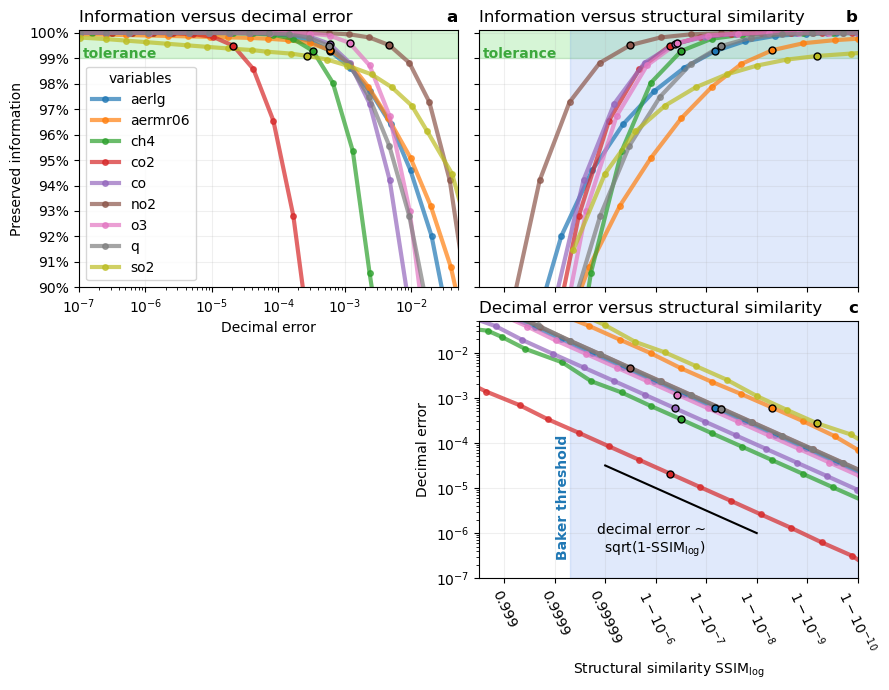

In [6]:
fig,(ax1,ax3,ax2,ax4) = subplots(2,2,figsize=(9,7))

ax1.set_xscale("log")
ax4.set_yscale("log")
ax3.axis("off")

for i in 1:nvars
    ax1.plot(dec_error[i,:],pres_info[i,:],"C$(i-1)o-",label=varnames[i],ms=4,alpha=0.7,lw=3)
    k99 = argmax(pres_info[i,:] .> 99)
    ax1.scatter(dec_error[i,k99],pres_info[i,k99],25,edgecolor="k",zorder=10)
#     ax1.text(dec_error[i,k99],pres_info[i,k99]," $k99")
end

for i in 1:nvars
    # use max to set ssim>1 to 1
    ax2.plot(-log10.(max.(0,1 .- ssimlog[i,:])),pres_info[i,:],"C$(i-1)o-",ms=4,alpha=0.7,lw=3)
    k99 = argmax(pres_info[i,:] .> 99)
    ax2.scatter(-log10.(max.(0,1 .- ssimlog[i,k99])),pres_info[i,k99],25,edgecolor="k",zorder=10)
end

for i in 1:nvars
    # use max to set ssim>1 to 1
    ax4.plot(-log10.(max.(0,1 .- ssimlog[i,:])),dec_error[i,:],"C$(i-1)o-",ms=4,alpha=0.7,lw=3)
    k99 = argmax(pres_info[i,:] .> 99)
    ax4.scatter(-log10.(max.(0,1 .- ssimlog[i,k99])),dec_error[i,k99],25,edgecolor="k",zorder=10)
end

ax1.legend(loc=3,title="variables",fontsize=10)
ax1.set_ylabel("Preserved information")
ax1.set_xlabel("Decimal error")
ax4.set_ylabel("Decimal error")
ax4.set_xlabel(L"Structural similarity SSIM$_\log$")

ax1.set_ylim(90,100.1)
ax2.set_ylim(90,100.1)
ax1.set_xlim(1e-7,5e-2)
ax1.set_yticks(90:100)
ax2.set_yticks(90:100)
ax2.set_yticklabels([])
ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))

minexp = 3
maxexp = 10

ax2.set_xlim(minexp-0.5,maxexp)
ax4.set_xlim(minexp-0.5,maxexp)
ax4.set_ylim(ax1.get_xlim())

ax1.grid(alpha=.2)
ax2.grid(alpha=.2)
ax4.grid(alpha=.2)

tiks = 1 .- 10.0 .^(-minexp:-1:-maxexp)
tiklabls = vcat(["0.9","0.99","0.999","0.9999","0.99999"][minexp:end],
                [L"1-10^{-%$i}" for i in 6:maxexp])
ax2.set_xticks(-log10.(1 .- tiks))
ax4.set_xticks(-log10.(1 .- tiks))
ax2.set_xticklabels([])
ax4.set_xticklabels(tiklabls,rotation=-65)

# tolerance
for ax in (ax1,ax2)
    ax.fill_between(ax.get_xlim(),[99,99],[101,101],color="limegreen",alpha=.2)
    ax.text(0.01,0.935,"tolerance",color="C2",fontweight="bold",
        alpha=.9,va="top",transform=ax.transAxes)
end

baker_threshold = 0.99995
for ax in (ax2,ax4)
    ax.fill_between([-log10(1-baker_threshold),ax.get_xlim()[2]],
                    ones(2)*ax.get_ylim()[1],ones(2)*ax.get_ylim()[2],
                    color="cornflowerblue",alpha=.2)
end

ax4.text(-log10(1-baker_threshold),3e-7,"Baker threshold",rotation=90,ha="right",
            color="C0",fontweight="bold")


# decimal error proportional to sqrt(1-SSIM)?
ssims = [0.99999,0.99999999]
decers = sqrt.(1 .- ssims)
cons = 1e-2
ax4.plot(-log10.(1 .- ssims),cons*decers,"k")
ax4.text(0.6,0.1,"decimal error ~\n"*L"sqrt(1-SSIM$_{\log}$)",color="k",transform=ax4.transAxes,ha="right")

ax1.set_title("Information versus decimal error",loc="left")
ax2.set_title("Information versus structural similarity",loc="left")
ax4.set_title("Decimal error versus structural similarity",loc="left")
ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax4.set_title("c",loc="right",fontweight="bold")

tight_layout(h_pad=-1,w_pad=-3)
savefig("information_error_ssim.png",dpi=200)
savefig("information_error_ssim.pdf")